In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

from plato.planets.observation import ObservationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults

In [3]:
set_plot_defaults()

figure_directory = f"../figures/06_planet_population_metrics/"
save = True

In [4]:
LOPS2 = pd.read_csv(f"../data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(f"../data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

## CREATE MOCK OBSERVATIONS

In [8]:
# num_mocks = 300
# obs_model = ObservationModel(load_mocks=False)

# obs_model.create_mocks(fields, num_embryos=[10, 20, 50, 100], num_mocks=num_mocks)
# obs_model.create_mocks(
#     fields[fields["Population"] == "Halo"],
#     num_embryos=[10, 20, 50, 100],
#     metallicity_limit=-0.6,
#     num_mocks=num_mocks,
# )

## PLOT HEATMAPS

In [9]:
obs_model = ObservationModel(num_mocks=100)
period_bins = [0.5, 1, 2, 5, 10, 20, 50, 100, 250, 500, 750]

In [24]:
pops = {}
for pop in ["Thin Disk", "Thick Disk", "Halo", "Halo (Metallicity Cut)"]:
    data = obs_model.stats_pivot_table(
        num_embryos=[10, 50, 100],
        statistic="mean",
        population=pop if pop != "Halo (Metallicity Cut)" else "Halo",
        select_metallicity_cut_mocks=True if pop == "Halo (Metallicity Cut)" else False,
    )
    data_annots = obs_model.formatted_statistics(
        num_embryos=[10, 50, 100],
        population=pop if pop != "Halo (Metallicity Cut)" else "Halo",
        select_metallicity_cut_mocks=True if pop == "Halo (Metallicity Cut)" else False,
    )
    pops[pop] = (data, data_annots)

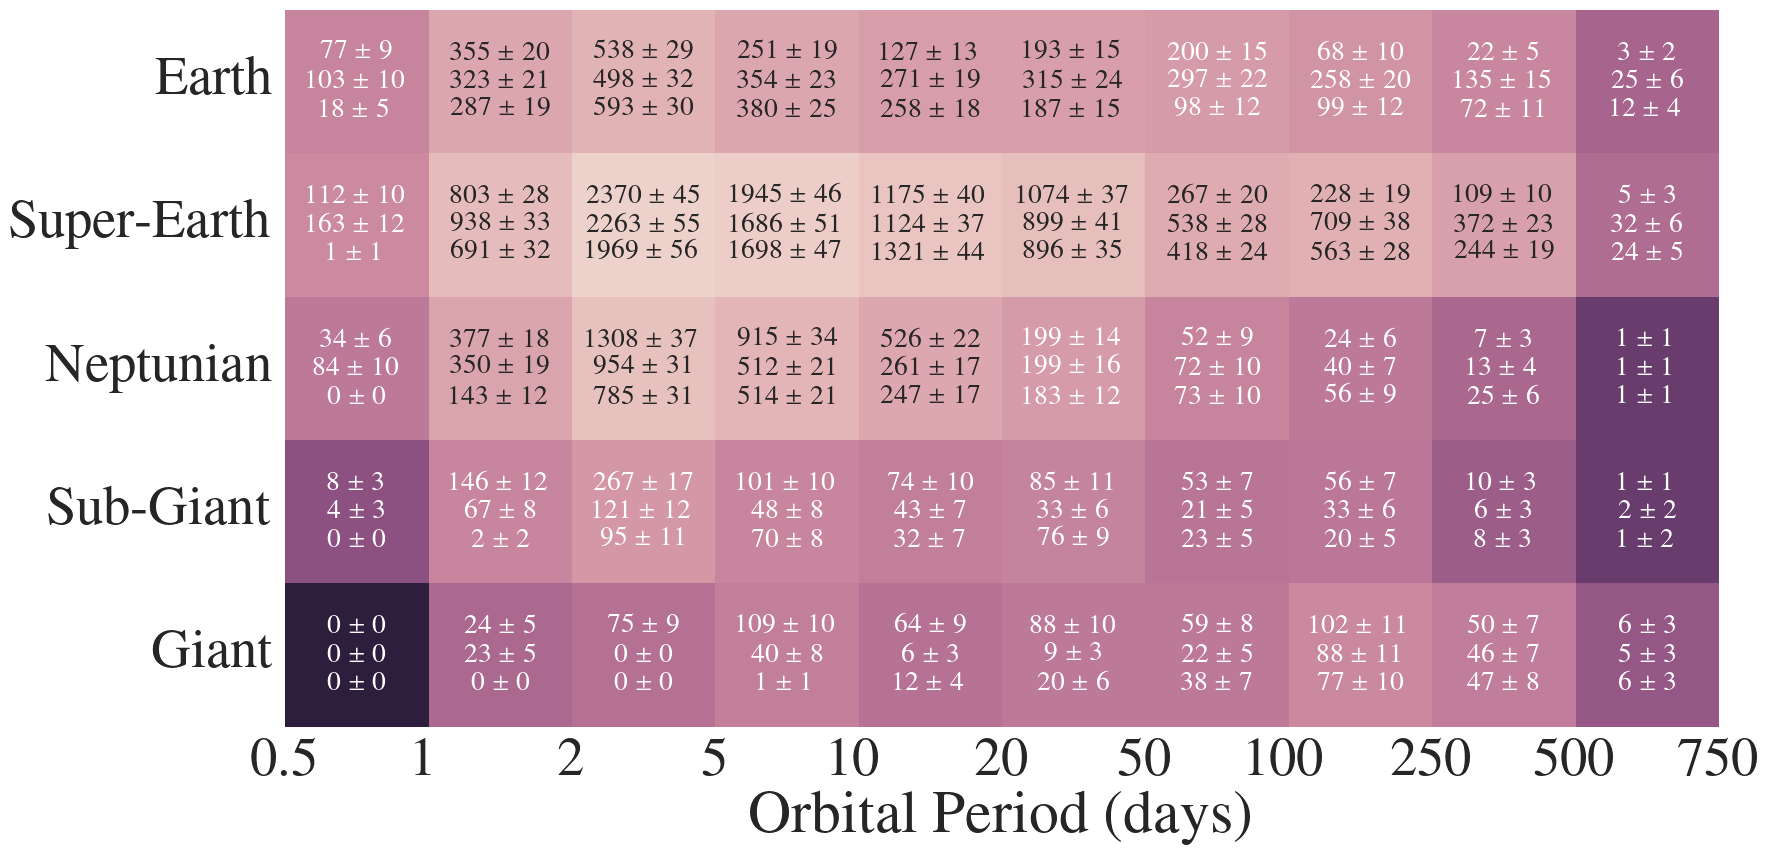

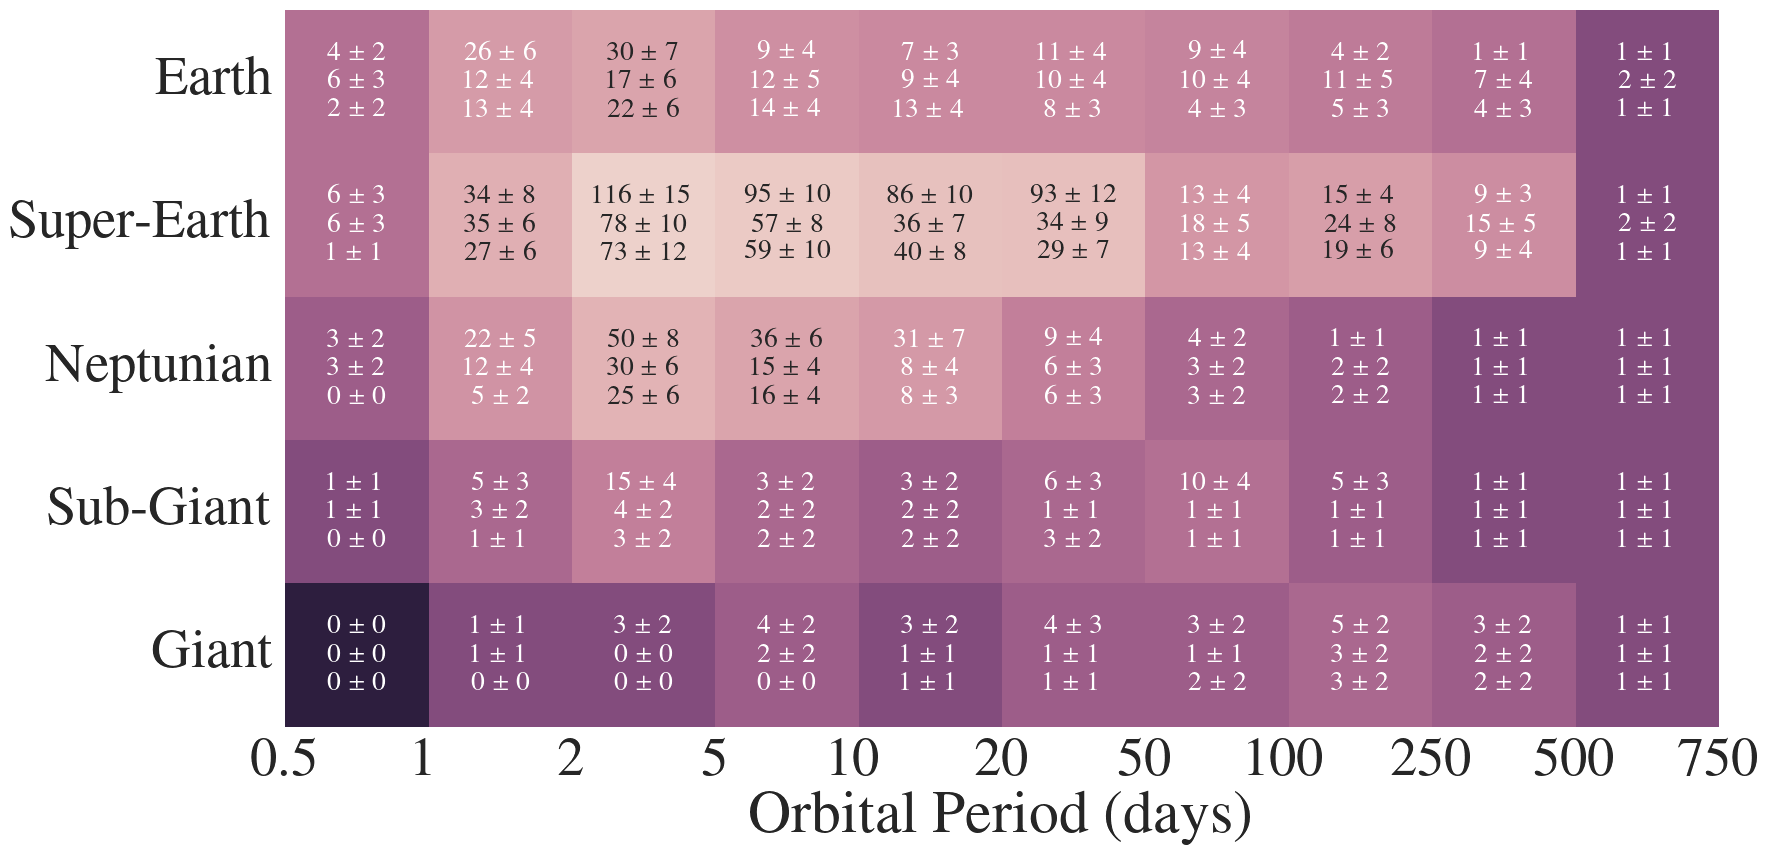

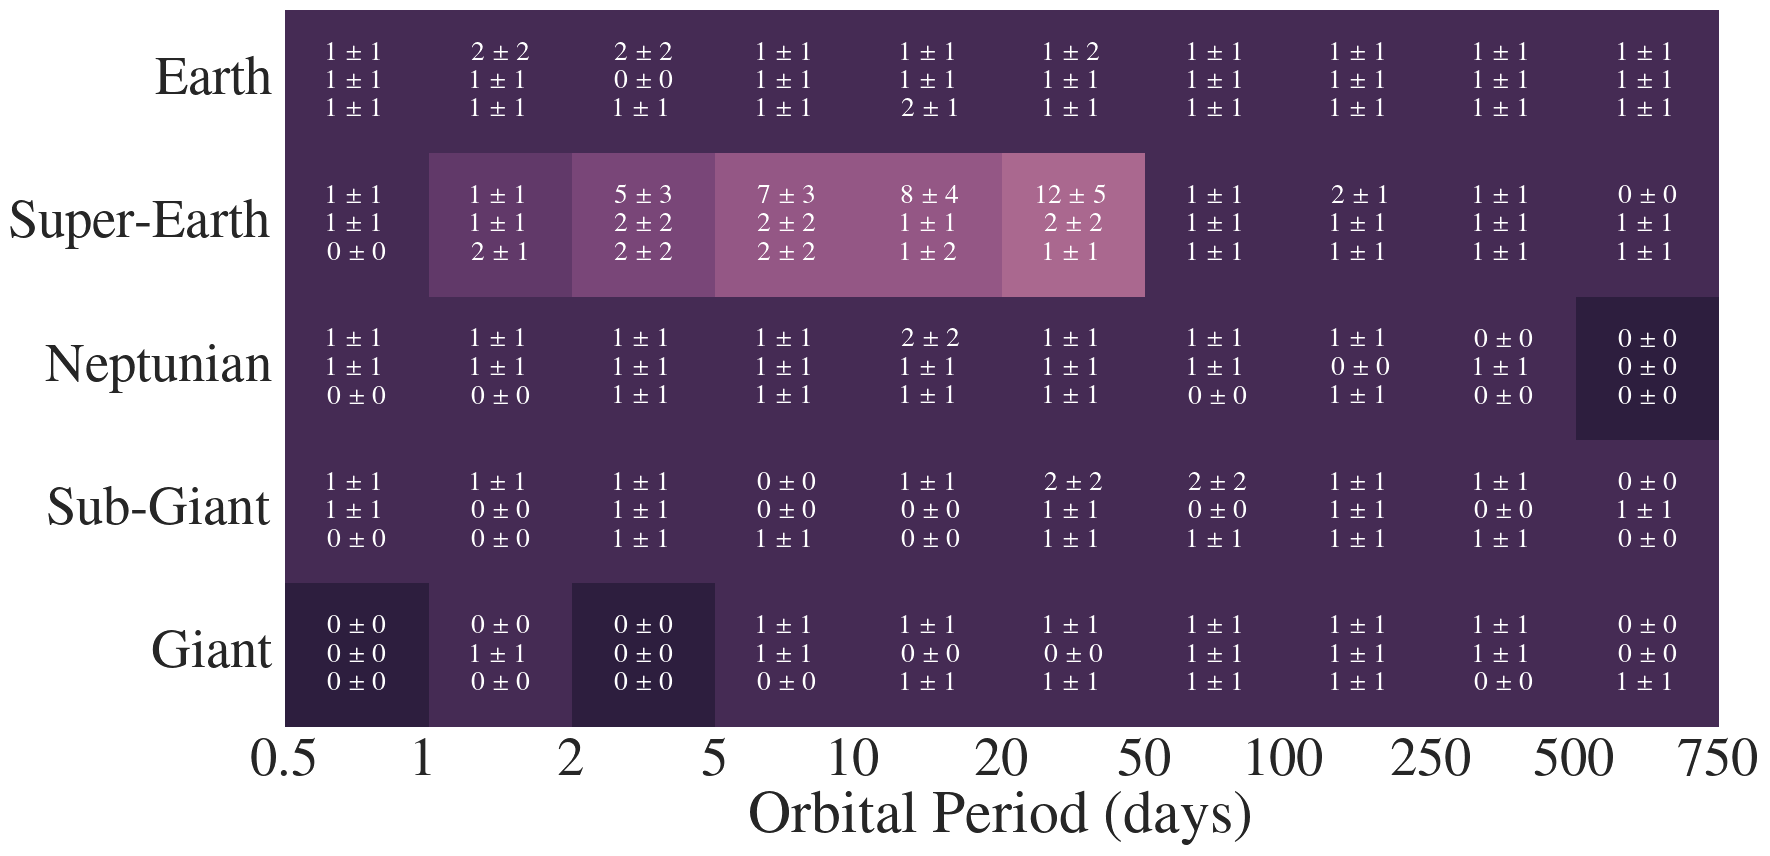

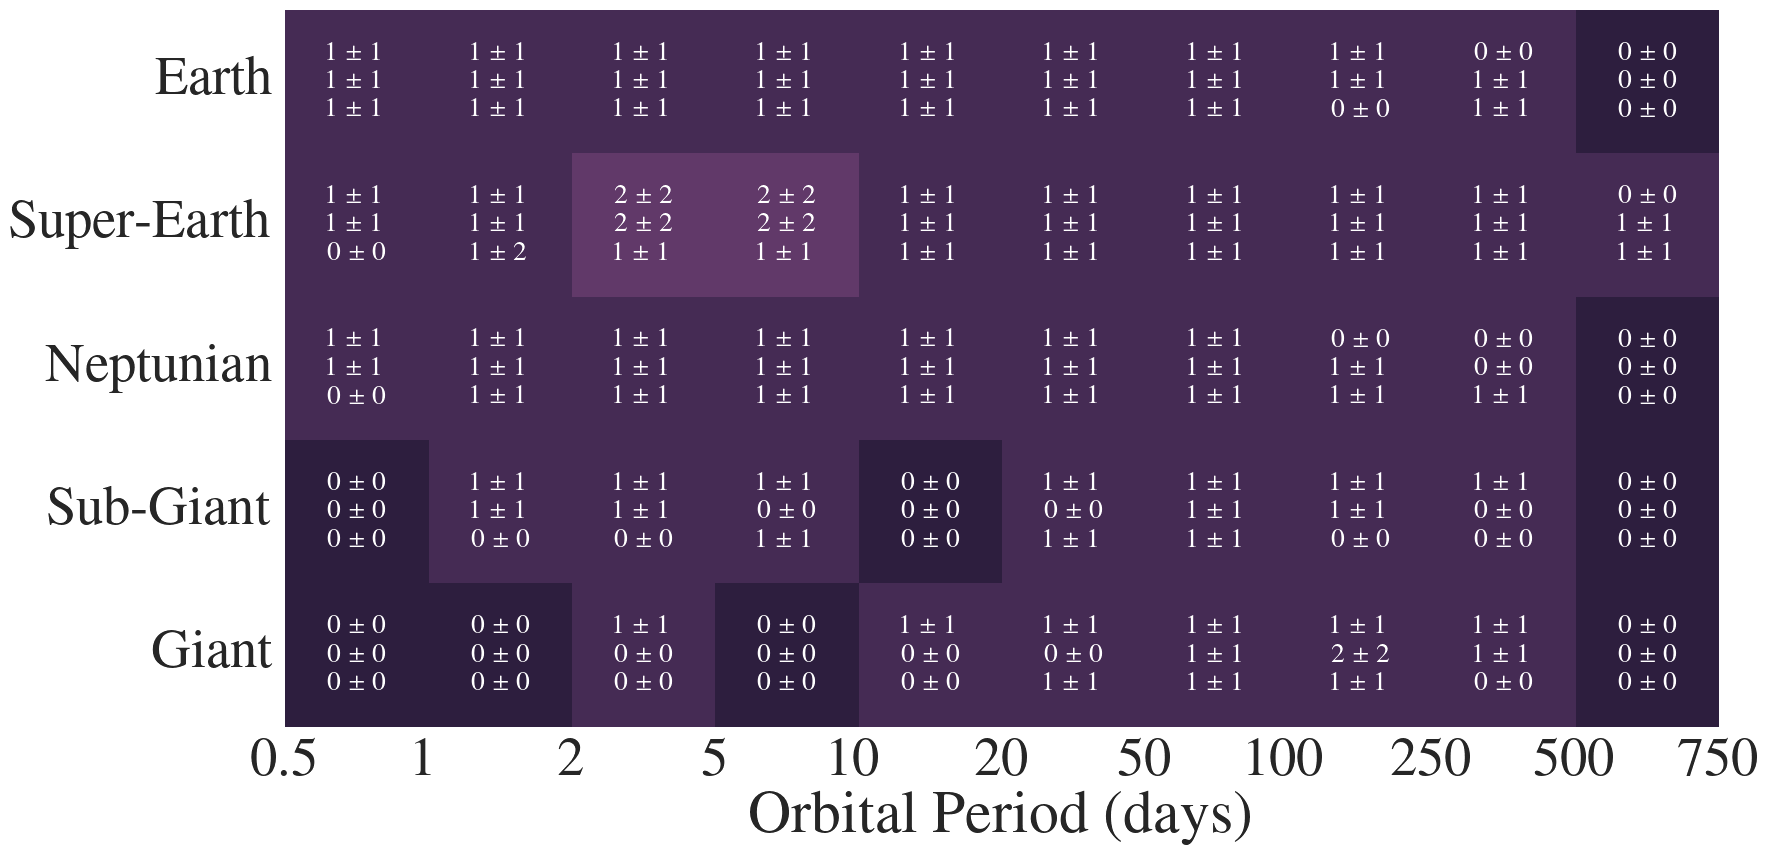

In [25]:
for pop_name, pop_val in pops.items():
    plt.figure()
    heatmap = sns.heatmap(
        pop_val[0],
        annot=pop_val[1],
        cbar=False,
        cmap=get_palette(as_cmap=True, reverse=True),
        annot_kws={"fontsize": 20},
        norm=LogNorm(vmin=0.1, clip=True) if "Halo" not in pop_name else None,
        vmax=10 if "Halo" in pop_name else None,
        fmt="",
        square=True,
    )

    heatmap.set_xlabel("Orbital Period (days)")
    heatmap.set_ylabel("")
    heatmap.set_xticks(
        ticks=np.arange(len(period_bins)),
        labels=period_bins,
    )

    figure_name_dict: dict = {
        "Thin Disk": "thin_disk",
        "Thick Disk": "thick_disk",
        "Halo": "halo",
        "Halo (Metallicity Cut)": "halo_metallicity_cut",
    }

    FigureProcessor(heatmap).save(
        f"observation_heatmap_{figure_name_dict[pop_name]}",
        figure_directory=figure_directory,
        save=save,
    )

In [67]:
num_embryos = [10, 20, 50, 100]

num_planets = {}

for num in num_embryos:
    num_planets_per_pop = {}
    for pop in ["Thin Disk", "Thick Disk", "Halo", "Halo (Metallicity Cut)"]:
        data = obs_model.stats_pivot_table(
            num_embryos=num,
            statistic="mean",
            population="Halo" if pop == "Halo (Metallicity Cut)" else pop,
            select_metallicity_cut_mocks=(pop == "Halo (Metallicity Cut)"),
        )
        num_planets_per_pop[pop] = data.values.sum().sum().astype(int)
    num_planets[num] = num_planets_per_pop

num_planets = pd.DataFrame.from_dict(num_planets, orient="columns")
num_planets.index.name = "Population"
num_planets.columns.name = "Number of Embryos"
num_planets

Number of Embryos,10,20,50,100
Population,,,,
Thin Disk,14743,16486,14406,12384
Thick Disk,805,1039,511,449
Halo,75,115,40,39
Halo (Metallicity Cut),39,41,37,31
